## Simulation Results
Here we present numerical simulations of a group of $N = 6$ robots manipulating a rigid body in $SE(3).$ We include implementations of both the typical adaptation law & one with l-p regularization.

In [1]:
#imports
using LinearAlgebra, NLsolve, Random, PyPlot, LaTeXStrings, PyCall
include("C:\\Users\\USER\\Simulation\\utils.jl")

vee (generic function with 1 method)

### Physical Parameters & Constants

In [2]:
#Physical parameters
rho = 100 #density, kg/m^3 
r = 0.5 #cylinder radius, m
h = 0.2 #cylinder height, m
m = rho*pi*(r^2)*h #cylinder mass, kg



r_p = [0,0,h/2] #measurement point
N = 6
r_i = [[0,0,0],[0,0,-h],[r,0,-h/2],[-r,0,-h/2],[0,r,-h/2],[0,-r,-h/2]]
# r_i = [[2,1,3],[2,-1,0]]

#compute inertia tensor
I_cm = (1/12)*Diagonal([m*(3*r^2+h^2),m*(3*r^2+h^2),6*m*r^2])
I_p = I_cm + m*(r_p'*r_p*I -r_p*r_p')


#frequencies & phase shifts for reference signal computation
num_freq = 15
ratio_l = 15
ratio_r = 10
freqs = rand(6,num_freq)
# phases = zeros(6,num_freq)
phases = 5*rand(6,num_freq)

#define  reference signals (combinations of sinusoids)
function w_d(t)
    w_dt = (ratio_r/length(freqs))*sum(vcat(cos.(freqs[1,:]*t.+phases[1,:])',sin.(freqs[2,:]*t.+phases[2,:])',cos.(freqs[3,:]*t.+phases[3,:])'),dims=2)[:]
    if dimension == 2
        w_dt[1] = 0
        w_dt[2] = 0
    end
    return w_dt
end

function al_d(t)
    al_dt = (ratio_r/length(freqs))*sum(vcat(-freqs[1,:]'.*sin.(freqs[1,:]*t.+phases[1,:])',freqs[2,:]'.*cos.(freqs[2,:]*t.+phases[2,:])',-freqs[3,:]'.*sin.(freqs[3,:]*t.+phases[3,:])'),dims=2)[:]
    if dimension == 2
        al_dt[1] = 0
        al_dt[2] = 0
    end
    return al_dt
end

function v_d(t)
    v_dt = (ratio_l/length(freqs))*sum(vcat(cos.(freqs[4,:]*t.+phases[4,:])',cos.(freqs[5,:]*t.+phases[5,:])',cos.(freqs[6,:]*t.+phases[6,:])'),dims=2)[:]
    if dimension == 2
        v_dt[3] = 0
    end
   return v_dt
end

function a_d(t)
    a_dt = (ratio_l/length(freqs))*sum(vcat(-freqs[4,:]'.*sin.(freqs[4,:]*t.+phases[4,:])',-freqs[5,:]'.*sin.(freqs[5,:]*t.+phases[5,:])',-freqs[6,:]'.*sin.(freqs[6,:]*t.+phases[6,:])'),dims=2)[:]
    if dimension == 2
        a_dt[3] = 0
    end
    return a_dt
end

function dq_des(t)
   return vcat(v_d(t),w_d(t)) 
end

function ddq_des(t)
   return vcat(a_d(t),al_d(t))
end

ddq_des (generic function with 1 method)

### Gain

In [3]:
# ICL gain
N_o = 20
ICL_update = false
ICL_switcher = false
k_cl_m = 0.0001
k_cl_rp = 0.0002
k_cl_I = 0.0003
k_cl_ri = 0.0002
k_cl_gain = Diagonal(vcat(k_cl_m,k_cl_rp*ones(3),k_cl_I*ones(6),k_cl_ri*ones(3)))

# gamma o
g_m = 4
g_rp = 5
g_I = 8
g_ri = 5
g_o = Diagonal(vcat(g_m,g_rp*ones(3),g_I*ones(6),g_ri*ones(3)))

#Kd matrix
Kdl = 12
Kdr = 12
Kd = Diagonal(vcat(Kdl*ones(3),Kdr*ones(3)))

#sliding parameter
lambda = 1.5

#deadband in which to stop adaptation
deadband = 0.001

#simulation parameters
dt = 0.01 #timestep -- numerical integration via Heun's; error is ~ O(dt^2)
T = 100 #final time
t_drop = T+10 #time for drop -- use t_drop < T for agents to turn off
dimension = 3 # n = 2 or n = 3

# addition random force
rand_f = false

false

### Reference input plot

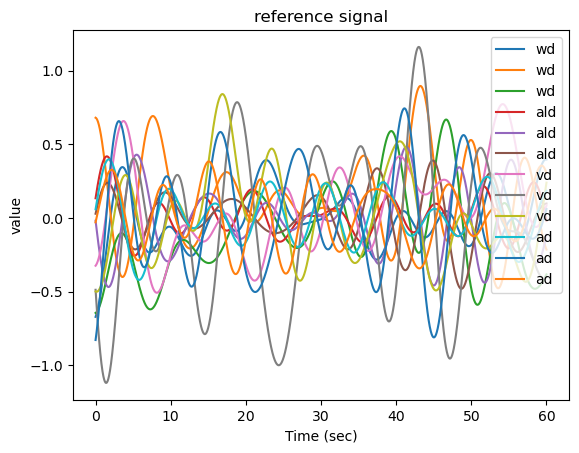

PyObject <matplotlib.legend.Legend object at 0x0000000063D29A60>

In [4]:
#reference signal plot
t = 0:0.02:60
label_ = ["wd", "ald", "vd", "ad"]

w_d_push = []
al_d_push = []
v_d_push = []
a_d_push = []

for i = 0:0.02:60
    push!(w_d_push, w_d(i))
    push!(al_d_push, al_d(i))
    push!(v_d_push, v_d(i))
    push!(a_d_push, a_d(i))
end

plot(t, w_d_push, label=label_[1])
plot(t, al_d_push, label=label_[2])
plot(t, v_d_push, label=label_[3])
plot(t, a_d_push, label=label_[4])
title("reference signal")
ylabel("value")
xlabel("Time (sec)");
legend(loc = 1)

### Initialize

In [5]:
##setup constants, etc.
# Random.seed!(318) #seed rand for repeatability

# a_hat = [2*randn(13) for i = 1:N] #initial a_hat
a_hat = [zeros(13) for i = 1:N]
# for i=1:N
#     a_hat[i][11:13] = r_i[i]
# end

# for i=1:N
#     a_hat[i][11:13] = 0.2*rand(3,1)
# end

#true a_i
a, a_i = [], []
a_I = [I_p[1,1], I_p[1,2], I_p[1,3], I_p[2,2], I_p[2,3], I_p[3,3]]
for i = 1:N
    push!(a,vcat(m,m*r_p,a_I,r_i[i]))
    push!(a_i, vcat(m,m*r_p,a_I,r_i[i])/N)
end

# Rank check
Rank_check = [0 0 0 0]

#initial r_hat
r_hat = [2*randn(3) for i = 1:N]

#sample random initial orientations
q = rand(4)
q = q/norm(q) #random quaternion
q_d = rand(4)
q_d = q_d/norm(q_d) #random desired quaternion
#cast both to rotation matrices
R = quat_to_rot(q)
R_d = quat_to_rot(q_d)

dq = zeros(6) #initial velocity = 0

#inital state
w = zeros(3)
x = zeros(3)
x_d = zeros(3)
dx = zeros(3)

#inital force
force = [zeros(3, 1) for i = 1:N]



p = 2 #l-p norm to be used for regularization;
#note: we only implement l1, l2, since physical scaling issues => numerical problems for p > 2.


P_o = 3e1*inv(Diagonal(ones(13)).+1e-2)
P_r = 3e1*inv(Diagonal(ones(3)))
tol=1e-5


#storage for sim. data
s_t = []
rot_err = []
V = []
s = zeros(6)
lyap_params = []
err_mean = []
arm_est = []
dV_params = []
true_tau = []

index = 1
mat_matrix = zeros(13, N_o, N)
dx_last = zeros(3)
w_last = zeros(3)
rand_force = []

force_debug = zeros(0,6)

param_est_sum = zeros(0, 13)
param_est_err = zeros(0, 10)

arm_est_sum = zeros(0, 3)
arm_est_err = zeros(0, N)



global H = vcat(hcat(m*I,m*skew(R*r_p)),
         hcat(-m*skew(R*r_p), R*I_p*R'))
verbose = false
dropped = false

false

### Dynamics Implementation

In [6]:
function adaptive_dyn(x,x_d,R,R_d,dq,a_hat,t;t_drop=Inf)
    #inputs: position x, desired pos. x_d, orientation R, des. orient. R_d, velocity dq, param estimates a_hat, r_hat, time t;
    #optional : drop time t_drop
    #outputs: state & parameter derivatives
    
    #unpack variables
    dx = deepcopy(dq[1:3])
    w = deepcopy(dq[4:6])
    
    #compute error signals
    Re = R_d'*R
    we = w - w_d(t)
    
    sigma = we + lambda*R_d*vee(Pa(Re))
    dx_t = dx - v_d(t)
    x_t = x - x_d
    
    s = vcat(dx_t+lambda*x_t,sigma)
    
    al_r = al_d(t) - lambda*skew(w_d(t))*R_d*vee(Pa(Re)) - lambda*R_d*vee(Pa(skew(R_d'*we)*Re))
    w_r = w_d(t) - lambda*R_d*vee(Pa(Re))
    a_r = a_d(t) - lambda*dx_t
    v_r = v_d(t) - lambda*x_t
     
    ddq_r = vcat(a_r, al_r)
    dq_r = vcat(v_r, w_r)
    
    #compute regressors
    Y_o = []
    for i = 1:N
        Y_l = hcat(a_r,-skew(al_r)*R-skew(w)*skew(w_r)*R,zeros(3,9))
        Y_r = hcat(zeros(3,1),skew(a_r)*R+skew(w)*skew(v_r)*R-skew(w_r)*skew(dx)*R,
            R*L(R'*al_r)+skew(w)*R*L(R'*w_r),skew(force[i])*R)
        push!(Y_o,vcat(Y_l,Y_r))
#         println(rank(skew(force[i])*R))
        global Rank_check[rank(skew(force[i])*R) + 1] = Rank_check[rank(skew(force[i])*R) + 1] + 1
    end
    
    #compute true dynamics matrices
    H = vcat(hcat(m*I,m*skew(R*r_p)),
         hcat(-m*skew(R*r_p), R*I_p*R'))
        
    C = vcat(hcat(zeros(3,3),m*skew(w)*skew(R*r_p)),
        hcat(-m*skew(w)*skew(R*r_p),skew(w)*R*I_p*R'-m*skew(skew(R*r_p)*dx)))
    
    off_diag = m*skew(w)*R*skew(r_p)*R' - m*R*skew(r_p)*R'*skew(w)
    H_dot = vcat(hcat(zeros(3,3),off_diag),
                    hcat(-off_diag,skew(w)*R*I_p*R'-R*I_p*R'*skew(w)))



    ### ICL
    y_o_cl_integral = []
    if ICL_update && ICL_switcher
        for i = 1:N
            y_l = hcat(dx-dx_last, -skew(w-w_last)*R-(skew(w)*skew(w)*R)*dt, zeros(3,9))
            y_r = hcat(zeros(3,1), skew(dx-dx_last)*R, R*L(R'*(w-w_last))+(skew(w)*R*L(R'*w))*dt, skew(force[i])*R*dt)
            push!(y_o_cl_integral,vcat(y_l, y_r))
        end
        
        if index > N_o
            global index = 1
        end

        for i = 1:N
            true_tau_integral = true_tau[i] * dt
            y_o_cl_integral_a_hat = y_o_cl_integral[i] * a_hat[i]
            mat_now = y_o_cl_integral[i]'*(y_o_cl_integral_a_hat - true_tau_integral)

            for j = 1:13 # 13 elements
                global mat_matrix[j, index, i] = mat_now[j]
            end
        end

        mat_sum = sum(mat_matrix, dims=2)


        global index = index + 1

    end

    global dx_last = dx
    global w_last = w

    ###


    
    #apply control law
    input = zeros(6)
    F = []
    global true_tau = []
    global force = []
    
    for i = 1:N
        push!(F,Y_o[i]*a_hat[i] - Kd*s) #implement control law

        if rand_f == true
            push!(rand_force, 0.3*rand(6))
            tau = F[i] + rand_force[i]
        else
            tau = F[i]  #compensate for est. torque
        end
        
        G = vcat(hcat(I,zeros(3,3)),hcat(skew(R*r_i[i]),I))
        input += G*tau #compute real applied wrench; add to running
        
        push!(true_tau, tau)
        push!(force,tau[1:3])
    end

    global force_debug = vcat(force_debug, input')



    #use root finding to solve for accelerations (avoid inverting H)
    f(ddq) = H*ddq + C*dq - input
    ddq = nlsolve(f,zeros(6),autodiff=:forward).zero
    
    #implement adaptation laws
    Y_g, dr, a_t, r_t = [], [], [], []
    da, g_r = [], [], []
    
    for i = 1:N
        ### ICL
        if ICL_update && ICL_switcher
            push!(da,-g_o*Y_o[i]'*s-k_cl_gain*g_o*reshape(mat_sum[:, 1, i], 13))
        ###
        else
            push!(da,-g_o*Y_o[i]'*s)
        end
        push!(a_t,a_hat[i]-a_i[i])
    end
    
    global ICL_update = true
    
    ds = ddq - ddq_r
    ds2 = vcat(ddq[1:3]-a_d(t)+lambda*(dx-v_d(t)),
        ddq[4:6]-al_d(t)+lambda*(skew(w_d(t))*R_d*vee(Pa(Re)) + R_d*vee(Pa(skew(R_d'*we)*Re))))
    
    dV = s'*(-H*ddq_r - C*dq_r)  #s'(-Y_oo_i)
    dV2 = s'*H*ds + (1/2)*s'*H_dot*s
    r_err = 0
    o_err = 0
    
    for i = 1:N
        dV += s'*(F[i])+ a_t[i]'*inv(g_o)*da[i]
        dV2 += a_t[i]'*inv(g_o)*da[i]
    end
    
    if verbose
        @show norm(H_dot-2*C+(H_dot-2*C)')/norm(H_dot-2*C) #check H_dot-2*C s.s.
        @show dV #check dV <= 0
        @show dV - dV2 #check dV equal when computed 2 different ways
        @show dV + N*s'*Kd*s #check dV = -N*s'*Kd*s
        @show norm(ds-ds2) #check ds equal when computed 2 different ways
    end
    
    #output accelerations & derivatives
    return ddq, da, dr, dV, ds
end

adaptive_dyn (generic function with 1 method)

### Run Simulations

In [7]:
##############################
###### Simulation Start ######
##############################
for t in 0:dt:T
    if t >= t_drop && !dropped
        N = convert(Int,N/2) # ensure that N is a integer
        dropped = true
    end
    
    #unpack variables
    dx = deepcopy(dq[1:3])
    w = deepcopy(dq[4:6])

    #compute error signals
    Re = R_d'*R
    we = w - w_d(t)
    sigma = we + lambda*R_d*vee(Pa(Re))
    dx_t = dx - v_d(t)
    x_t = x - x_d
    s = vcat(dx_t+lambda*x_t,sigma)
    
#     check if simulation has diverged -- if so, decrease dt
    if norm(s) > 1e3
        @warn "diverged"
        break
    end
    
    #dynamics matrices (for debug)
    H = vcat(hcat(m*I,m*skew(R*r_p)),
         hcat(-m*skew(R*r_p), R*I_p*R'))
    
    C = vcat(hcat(zeros(3,3),m*skew(w)*skew(R*r_p)),
        hcat(-m*skew(w)*skew(R*r_p),skew(w)*R*I_p*R'-m*skew(skew(R*r_p)*dx)))
    ## for H dot
    off_diag = m*skew(w)*R*skew(r_p)*R' - m*R*skew(r_p)*R'*skew(w)
    H_dot = vcat(hcat(zeros(3,3),off_diag),
                    hcat(-off_diag,skew(w)*R*I_p*R'-R*I_p*R'*skew(w)))
    
    #compute Lyap. function & param errors
    a_t = []

    V_curr = 0.5*(s'*H*s)

    for i = 1:N
        push!(a_t,a_hat[i]-a_i[i])
        V_curr += pnorm_divergence(P_o*a_i[i],P_o*a_hat[i],p,tol)
    end
    
    push!(V,V_curr)

    at_mean = (1/N)*sum(a_t)
    
    #logging
    push!(s_t,norm(s))
    push!(rot_err,norm(R_d'*R-I))
    
    
    ######################
    ###### Dynamics ######
    ######################
    #get dynamics @ current time
    global rand_force = []
    ddq, da, dr, dV, ds = adaptive_dyn(x,x_d,R,R_d,dq,a_hat,t)
        
    for i = 1:N
        if norm(s) > deadband #if above deadband, update parameters
            a_hat[i] = a_hat[i] + dt*da[i]
        else
            a_hat[i] = a_hat[i]
        end
    end
    
    R_d = exp(dt*skew(w_d(t)))*R_d
    R = exp(dt*skew(w))*R
    
    x_d = x_d + dt*v_d(t)
    x = x + dt*dx
    dq = dq + dt*ddq
    
    dx = deepcopy(dq[1:3])
    w = deepcopy(dq[4:6])

    
    param_est_sum = vcat(param_est_sum, sum(transpose(hcat([a_hat[i] for i = 1:N]...)), dims = 1))
    param_est_err = vcat(param_est_err, sum(transpose(hcat([a_hat[i][1:10] for i = 1:N]...)), dims = 1)-a[1][1:10]')
    
#     arm_est_sum = vcat(arm_est_sum, sum(transpose(hcat([r_hat[i] for i = 1:N]...)), dims = 1))
    arm_est_err = vcat(arm_est_err, hcat([norm(a_hat[i][11:13]-r_i[i]) for i = 1:N]...))
end


s_l2 = s_t;
rot_l2 = rot_err;
lyap_l2 = V;
arm_l2 = arm_est;

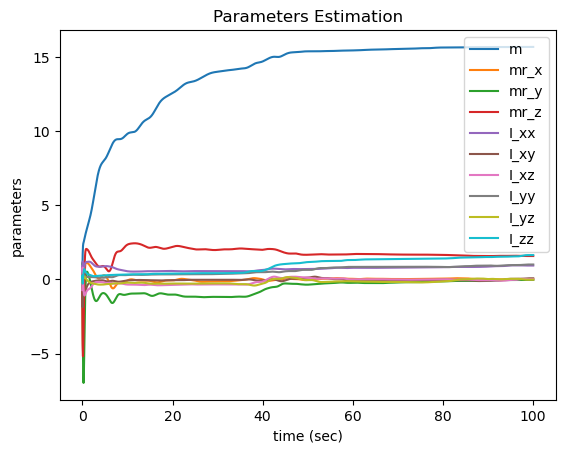

PyObject <matplotlib.legend.Legend object at 0x0000000063E6FB50>

In [8]:
#parameters estimation plot
t = 0:dt:T
label_ = ["m", "mr_x", "mr_y", "mr_z", "I_xx", "I_xy", "I_xz", "I_yy", "I_yz", "I_zz"]
for i = 1:10
    plot(t,param_est_sum[:, i], label=label_[i])
end
title("Parameters Estimation")
ylabel("parameters")
xlabel("time (sec)");
legend(loc = 0)

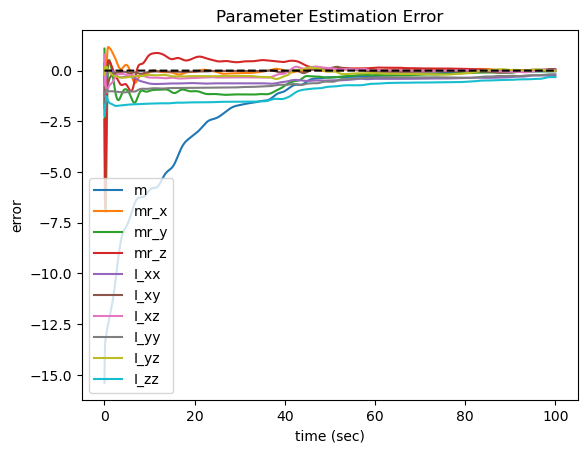

PyObject <matplotlib.legend.Legend object at 0x000000009975CA00>

In [9]:
#parameters estimation error plot
t = 0:dt:T
label_ = ["m", "mr_x", "mr_y", "mr_z", "I_xx", "I_xy", "I_xz", "I_yy", "I_yz", "I_zz"]
for i = 1:10
    plot(t,param_est_err[:, i], label=label_[i])
end
plot(t, zero(t), linestyle = "--", :black)
title("Parameter Estimation Error")
ylabel("error")
xlabel("time (sec)");
legend(loc = 3)

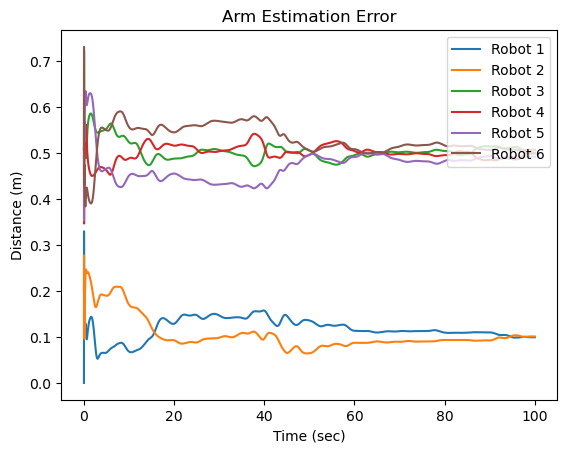

PyObject <matplotlib.legend.Legend object at 0x000000009AD70610>

In [10]:
#arm estimation error plot
t = 0:dt:T
label_ = ["Robot 1", "Robot 2", "Robot 3", "Robot 4", "Robot 5", "Robot 6"]
for i = 1:N
    plot(t,arm_est_err[:, i], label=label_[i])
end
title("Arm Estimation Error")
ylabel("Distance (m)")
xlabel("Time (sec)");
legend(loc = 1)

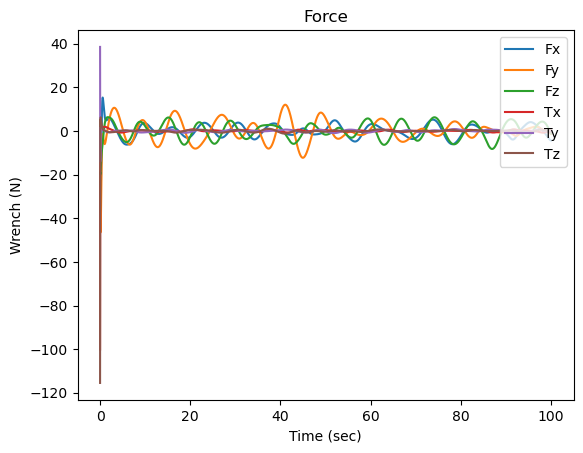

PyObject <matplotlib.legend.Legend object at 0x00000000999BFDF0>

In [11]:
t = 0:dt:T
label_ = ["Fx", "Fy", "Fz", "Tx", "Ty", "Tz"]
for i = 1:6
    plot(t,force_debug[:,i], label=label_[i])
end
title("Force")
ylabel("Wrench (N)")
xlabel("Time (sec)");
legend(loc = 1)

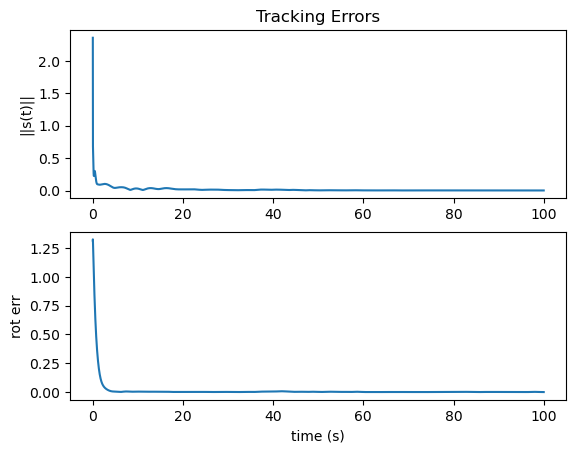

In [12]:
#error plot
t = 0:dt:T
fig, axs = PyPlot.subplots(2)
axs[1].set_ylabel("||s(t)||")
axs[1].set_title("Tracking Errors")
axs[1].plot(t,s_l2,label="l2")
#axs[1].plot(t,s_na,label="no arms")
#axs[1].plot(t,s_pd,label="pd")

axs[2].set_xlabel("time (s)")
axs[2].set_ylabel("rot err")
axs[2].plot(t,rot_l2);
#axs[2].plot(t,rot_na);
#axs[2].plot(t,rot_pd);

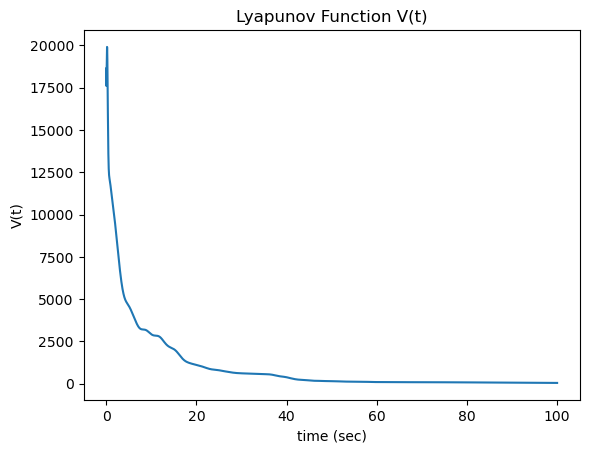

In [13]:
#Lyapunov function
plot(t,lyap_l2)
title("Lyapunov Function V(t)")
ylabel("V(t)")
xlabel("time (sec)");

In [14]:
for i=1:N
    println(a_hat[i][11:13])
end

[0.001380554790876941, 0.007581553447912805, -0.09911451941081122]
[0.001380554790876941, 0.007581553447912805, -0.09911451941081122]
[0.001380554790876941, 0.007581553447912805, -0.09911451941081122]
[0.001380554790876941, 0.007581553447912805, -0.09911451941081122]
[0.001380554790876941, 0.007581553447912805, -0.09911451941081122]
[0.001380554790876941, 0.007581553447912805, -0.09911451941081122]


In [15]:
x = 0
y = 0
z = 0
for i=1:N
    x += a_hat[i][11]
    y += a_hat[i][12]
    z += a_hat[i][13]
end
print(x, y, z)

0.0082833287452616450.04548932068747684-0.5946871164648673

In [16]:
println(r_i)

[[0.0, 0.0, 0.0], [0.0, 0.0, -0.2], [0.5, 0.0, -0.1], [-0.5, 0.0, -0.1], [0.0, 0.5, -0.1], [0.0, -0.5, -0.1]]


In [17]:
println(s_t[5001])
print(V[5001])

0.002227328061473635
147.6548566185034